<a href="https://colab.research.google.com/github/sohiniroych/AI_with_Sohini_Notebooks/blob/main/ST_scene_category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This code implements the baseline spatio-temporal method to automatically classify video sequences for night time, poor lighting and city/pedestrian content per frame. Also key frame selection happens in frames that have very high uncertainty.
[This](https://tfhub.dev/tensorflow/collections/object_detection/1) collection contains TF 2 object detection models that have been trained on the COCO 2017 dataset. [Here](https://tfhub.dev/s?module-type=image-object-detection) you can find all object detection models that are currently hosted on [tfhub.dev](https://tfhub.dev/).

## Imports and Setup

Let's start with the base imports. This code required Tensorflow version 2.7.0

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        # This Colab requires TF 2.5.
!pip install -U tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 22 kB/s 
     |████████████████████████████████| 1.3 MB 14.6 MB/s 
     |████████████████████████████████| 463 kB 74.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.9.2 req

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow_hub as hub
import time

tf.get_logger().setLevel('ERROR')

## Utilities

Run the following cell to create some utils that will be needed later:

- Helper method to load an image
- Map of Model Name to TF Hub handle
- List of tuples with Human Keypoints for the COCO 2017 dataset. This is needed for models with keypoints.

In [ ]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]


## Visualization tools

To visualize the images with the proper detected boxes, keypoints and segmentation, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models/

fatal: destination path 'models' already exists and is not an empty directory.


Intalling the Object Detection API

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Using cached tensorflow-2.9.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694955 sha256=e234f3ec88355b3ef3b42e0f5fc6fd96c2cc5afba2791021c00e5b1a4a9efccf
  Stored in directory: /tmp/pip-ephem-wheel-cache-3npxgbem/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


Now we can import the dependencies we will need later

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Build a detection model and load pre-trained model weights

Here we will choose which Object Detection model we will use.
Select the architecture and it will be loaded automatically.
If you want to change the model to try other architectures later, just change the next cell and execute following ones.

## Loading the selected model from TensorFlow Hub

Here we just need the model handle that was selected and use the Tensorflow Hub library to load it to memory.


In [ ]:
# Start with teh FasterRCNN model
model_handle="https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1"
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


## Loading an image

Let's try the model on a simple image. To help with this, we provide a list of test images.

Here are some simple things to try out if you are curious:
* Try running inference on your own images, just upload them to colab and load the same way it's done in the cell below.
* Modify some of the input images and see if detection still works.  Some simple things to try out here include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).

**Be careful:** when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.



In [ ]:
# First lets connect the Gdrive that contains the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Colab Notebooks/JAAD/DataX/JAAD/images/video_0024/')
files=os.listdir('./')

In [ ]:
# running inference
def model_inference(image_np, hub_model):
  #start_time = time.time()
  results = hub_model(image_np)
  result = {key:value.numpy() for key,value in results.items()}
  #end_time = time.time()
  #print("Inference time:",end_time-start_time)
  return result

# Next we analyze the metrics to  track the following:
1. Retain only: person, car, van, truck, train, bicycle
2. Count #P(person, bicycle) [1,2], #C(car, van, bus, truck, train) [3,4,6,7,8]
3. Find median prob of objects of interest (#M).
4. Send #P, #C, #M to wandb per image

Working as dataframe is easy!

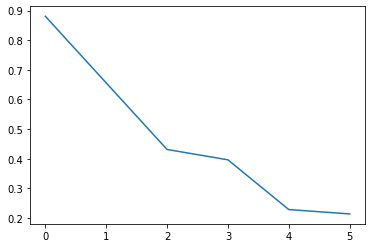

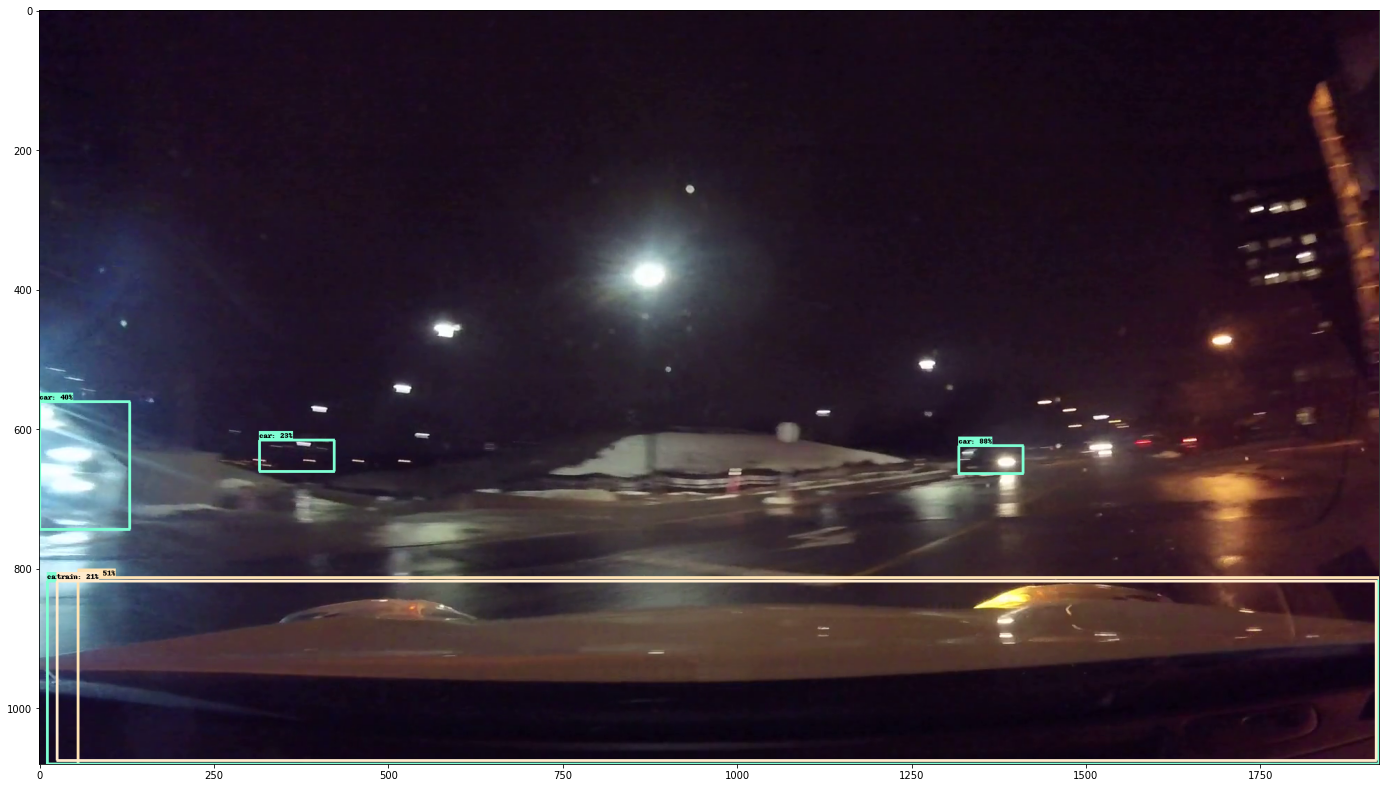

In [ ]:
import pandas as pd
img_path='./'+files[5]
image_np=load_image_into_numpy_array(img_path)
result=model_inference(image_np, hub_model)
label_id_offset = 0
image_np_with_detections = image_np.copy()
df=pd.DataFrame(columns=["scores","class"])
cl=np.array(result['detection_classes'][0].astype(int))
sc=np.array((result['detection_scores'][0]).astype(float))
df['scores']=sc
df['class']=cl
df1=df.loc[df['scores']>0.15]
U=df1.loc[(df1['class']>0) & (df1['class']<9)]
P=U.loc[(U['class']>0) & (U['class']<3)]
C=U.loc[(U['class']>2) & (U['class']<9)]
plt.plot(U['scores'])

# Now visualize all objects within the image with prob>0.15
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.15,
      agnostic_mode=False)#,
      #keypoints=keypoints,
      #keypoint_scores=keypoint_scores,
      #keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,24))
plt.imshow(image_np_with_detections[0])
plt.show()



In [ ]:
# Use a separate algorithm to detect background color.
BG=np.zeros(len(files))

In [ ]:
#Next, compute the number of pedestrians and cars and uncertainity in objectness per frame 
#Plot for one video sequence (0280 vs 0023)
import pandas as pd

Pe=np.zeros((len(files)))
Ca=np.zeros((len(files)))
BG=np.zeros(len(files))
Un=np.zeros(len(files))
for i in range(75):#range(len(files)):
  
  img_path='./'+files[i]
  image_np=load_image_into_numpy_array(img_path)
  start_time = time.time()
  result=model_inference(image_np, hub_model)
  image_np_with_detections = image_np.copy()
  df=pd.DataFrame(columns=["scores","class"])
  cl=np.array(result['detection_classes'][0].astype(int))
  sc=np.array((result['detection_scores'][0]).astype(float))
  df['scores']=sc
  df['class']=cl
  df1=df.loc[df['scores']>0.15]
  U=df1.loc[(df1['class']>0) & (df1['class']<9)]
  if(len(U)>0):
    P=U.loc[(U['class']>0) & (U['class']<3)]
    C=U.loc[(U['class']>2) & (U['class']<9)]
    Pe[i]=len(P)
    Ca[i]=len(C)
    Un[i]=np.std(U['scores'])/np.median(U['scores'])
  end_time=time.time()
  #print("Processing Time for ", i, "=", end_time-start_time)

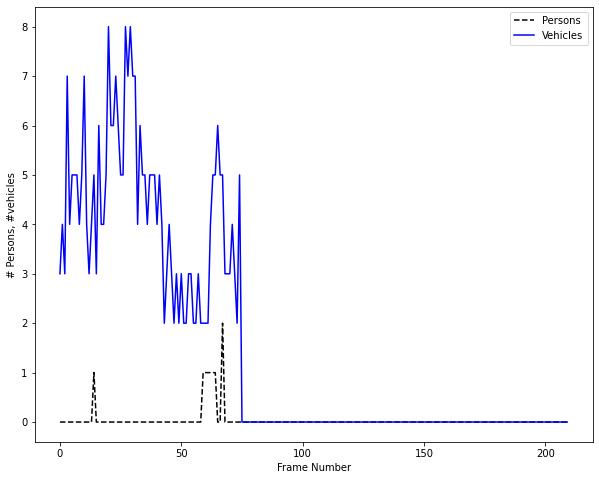

In [ ]:
fig, ax=plt.subplots(figsize=(10,8))
ax.plot(range(len(files)), Pe, 'k--', label='Persons')
ax.plot(range(len(files)),Ca,'b-', label='Vehicles')
ax.set_xlabel('Frame Number')
ax.set_ylabel('# Persons, #vehicles')
legend = ax.legend(loc='upper right')

plt.show()

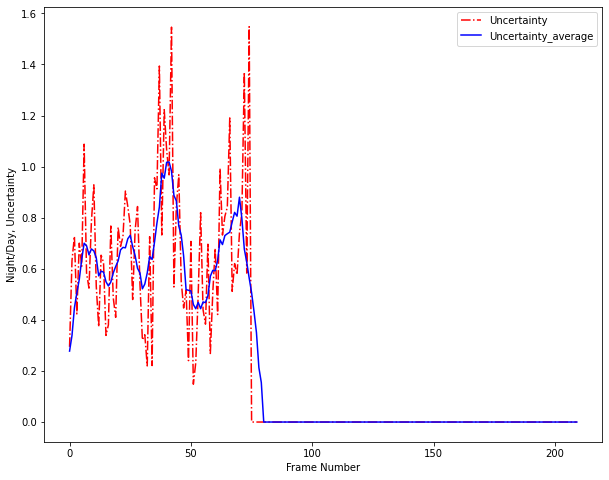

In [ ]:
# Find a 10 step average for Un
Un_a=np.convolve(Un, np.ones(10)/10, mode='same')
fig, ax=plt.subplots(figsize=(10,8))
ax.plot(range(len(files)), Un, 'r-.', label='Uncertainty')
ax.plot(range(len(files)), Un_a, 'b-', label='Uncertainty_average')
#ax.plot(range(len(files)),BG,'k', label='Night (1)/Day (0)')
ax.set_xlabel('Frame Number')

ax.set_ylabel('Night/Day, Uncertainty')
legend = ax.legend(loc='upper right')


## Notice the frames where uncertainity is >1 std dev over the 10 step averaged value. These are key frames that need to be separated for additional annotation.

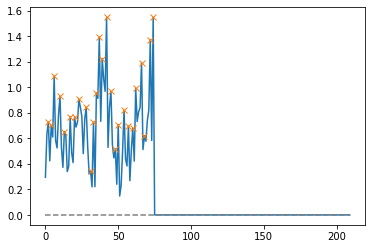

In [ ]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(Un,height=0)
plt.plot(Un)
plt.plot(peaks, Un[peaks], "x")
plt.plot(np.zeros_like(Un), "--", color="gray")
plt.show()


In [ ]:
def return_scene_category_per_frame(Pe,Ca,Un, BG):
  # Un here is the 10 frame moving average (5 frames before and 5 frames after)
  if((Pe>=0) & (Ca >0)): # Change this back for KITTI
    # It is city
    if (BG==1):
      # It is night
      label=4
    else: # It is day, city
      if (Un>0.5): 
        label=2
      else:
        label=0
  elif((Pe>=0) & (Ca==0)):
    # It is Pedestrians only
    if(BG==1): #It is night
      label=5
    else:
      if(Un>0.5):
        label=3
      else:
        label=1
  elif((Pe==0) & (Ca>0)):
    #It is highway
    if(BG==1): #It is night
      label=7
    else:
        label=7
  else:
    label=8

  return(label)

In [ ]:
ypred=np.zeros((75))
for i in range(75):
  print(i)
  BG[i]=1
  ypred[i]=return_scene_category_per_frame(Pe[i],Ca[i], Un_a[i], BG[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


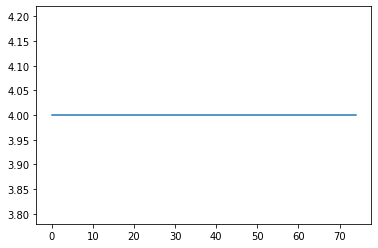

In [ ]:
plt.plot(ypred)